# Imports and Setup

The `transformers` and `torchaudio` libraries are used to load and manipulate pretrained Wav2Vec2 models. `librosa` is employed for audio signal processing, while `pandas` and `numpy` help manage metadata and numerical operations. `matplotlib` and `seaborn` are used for data visualization, and `sklearn` provides machine learning utilities. We also mount Google Drive to access the dataset and save extracted features and models persistently.

In [ ]:
# Install required packages
!pip install -q transformers torchaudio librosa scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00


In [ ]:
# Core imports
import os
import torch
import torch.nn as nn
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    top_k_accuracy_score,
    precision_recall_fscore_support
)
from sklearn.model_selection import train_test_split

In [ ]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this part, we define paths to key directories within Google Drive where data, extracted features, and results will be stored. The paths are centralized under `DRIVE_ROOT`, ensuring all outputs and intermediate files are consistently saved and retrieved from the same project location. This is crucial for reproducibility and organization across different runs of the notebook for the different team members.

In [ ]:
# Set up file paths
DRIVE_ROOT = '/content/drive/MyDrive/emotion_recognition_project'
metadata_path = os.path.join(DRIVE_ROOT, 'processed_metadata.csv')

In [ ]:
# Create directories for saving features and models
FEATURE_DIR = os.path.join(DRIVE_ROOT, 'experiments')
os.makedirs(FEATURE_DIR, exist_ok=True)

SEQUENCE_DIR = os.path.join(DRIVE_ROOT, 'sequences')
os.makedirs(SEQUENCE_DIR, exist_ok=True)

# Data Loading and preprocessing

We load the processed metadata CSV containing references to audio files paths, labels, and quality assurance flags (e.g., `processed_success`). Only successfully processed samples are retained (In the oreoricessing step all files were successfully processed). We also create a label mapping to encode the categorical emotion labels into integers, which are later used for classification [from emotion label strings ('happy', 'sad'...) to integers (0, 1, ...)].

In [ ]:
# Load and filter dataset
df = pd.read_csv(metadata_path)
df = df[df['processed_success'] == True].reset_index(drop=True)

# Create label mapping
label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['label'].map(label_map)

We also define a PyTorch `Dataset` class to load and preprocess raw audio waveforms. Each waveform is either padded or truncated to a fixed length (4 seconds or 64000 samples at 16kHz). This preprocessing ensures that all audio samples have the same shape, which is a requirement for model input. This class feeds clean and uniform waveform inputs into our experiments.

*Note: in the preprocessing stage, the audio files were already resampled and correctly convertetd to the desired input*

In [ ]:
# Dataset class definition
class SERFrozenWav2Vec2Dataset(Dataset):
    def __init__(self, df, processor, max_length=64000):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['processed_path']
        label = row['labels']

        speech, _ = librosa.load(path, sr=16000)
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)))

        return speech, label


We load Facebook's `wav2vec2-base` pretrained model and processor from Hugging Face.

The processor converts raw waveform into model-compatible tensors, and the model itself outputs hidden representations from multiple layers. We set `output_hidden_states=True` to retrieve the intermediate layer outputs required for the later experiments.


In [ ]:
# Load Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base', output_hidden_states=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

To evaluate model performance fairly, we split the dataset into training and testing subsets using stratified sampling to preserve label distribution. These subsets are converted into our custom `SERFrozenWav2Vec2Dataset` instances for our specific use.

In [ ]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
train_dataset = SERFrozenWav2Vec2Dataset(train_df, processor)
test_dataset = SERFrozenWav2Vec2Dataset(test_df, processor)

# Utility functions

This section provides helper functions to save and load extracted features and sequence data to/from disk. Evaluation metrics and confusion matrices are also defined here, enabling standardized performance reporting across all of the Wav2Vec2 related experiments.

In [ ]:
# Feature storage and loading utilities
def save_features(X, y, prefix):
    exp_dir = os.path.join(FEATURE_DIR, prefix)
    os.makedirs(exp_dir, exist_ok=True)
    np.save(os.path.join(exp_dir, f"X.npy"), X)
    np.save(os.path.join(exp_dir, f"y.npy"), y)

def load_features(prefix):
    exp_dir = os.path.join(FEATURE_DIR, prefix)
    X = np.load(os.path.join(exp_dir, f"X.npy"))
    y = np.load(os.path.join(exp_dir, f"y.npy"))
    return X, y

def save_sequences(X, y, name):
    torch.save((X, y), os.path.join(SEQUENCE_DIR, f"{name}.pt"))

def load_sequences(name):
    return torch.load(os.path.join(SEQUENCE_DIR, f"{name}.pt"))

# Evaluation utility for all the experiements
def evaluate_classification(y_true, y_pred, y_probs, label_names, title):
    acc = accuracy_score(y_true, y_pred)
    top3 = top_k_accuracy_score(y_true, y_probs, k=3)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"\n{title} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Top-3 Accuracy: {top3:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(11,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()

# Generic model training function (for neural network  realted experiments)
def train_model(model, train_loader, val_loader, label_names, title, num_epochs=50, lr=1e-3, patience=5):
    """
    A reusable training function is defined to handle model optimization, early stopping, learning rate scheduling, and visualization.
    This function works for any model that takes tensor input and outputs logits. Evaluation and training plots are also handled here.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_corrects, total_train = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            train_corrects += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= total_train
        train_acc = train_corrects / total_train

        model.eval()
        val_loss, val_corrects, total_val = 0.0, 0, 0
        y_true, y_pred, y_probs = [], [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                probs = torch.softmax(outputs, dim=-1)
                y_true.append(labels.cpu())
                y_pred.append(preds.cpu())
                y_probs.append(probs.cpu())
                val_corrects += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= total_val
        val_acc = val_corrects / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch

        if epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_wts)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_probs = torch.cat(y_probs).numpy()

    evaluate_classification(y_true, y_pred, y_probs, label_names, title)

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title(f'{title} - Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.title(f'{title} - Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    return model

# Preparing sequence features for Neural Network Experiments

In this step, we extract sequence-based features from the **last hidden layer** of the Wav2Vec2 model. These features are necessary for neural architectures that process time-series data, such as **BiLSTM** and **Attention-based** models.

1. **Checks for existing cached features**:
   - Looks for pre-saved PyTorch tensors (`train_seq.pt`, `test_seq.pt`) to avoid recomputation.

2. **If not cached, extracts features from scratch**:
   - For each audio file:
     - Loads the waveform.
     - Feeds it into the **frozen Wav2Vec2 model** using the processor.
     - Extracts the **last hidden state**, which is a sequence of 768-dimensional embeddings (1 per frame).
   - These sequences are then **padded** to ensure uniform shape across samples.

3. **Saves extracted features**:
   - Saves both features and labels to disk for future reuse.

Output:
- `X_train_seq`, `y_train_seq`: Training sequence features and labels.
- `X_test_seq`, `y_test_seq`: Test sequence features and labels.

#### Why this step is very important:
- Sequence models (BiLSTM, Attention) require temporal data, not fixed-length embeddings.
- This step enables the model to leverage **frame-wise** audio patterns for better emotional recognition performance.

In [ ]:
def prepare_sequence_features():
    """
    Prepare sequence features from Wav2Vec2 last hidden layer for neural network experiments

    Returns:
        X_train_seq, y_train_seq, X_test_seq, y_test_seq: Sequence features and labels
    """
    print("\nPreparing Sequence Features for BiLSTM and Attention Experiments")
    try:
        X_train_seq, y_train_seq = load_sequences("train_seq")
        X_test_seq, y_test_seq = load_sequences("test_seq")
        print("[INFO] Loaded sequence features from disk")
    except:
        print("[INFO] Creating sequence features from scratch")
        X_train_seq, y_train_seq, X_test_seq, y_test_seq = [], [], [], []

        # Process training data
        for waveform, label in tqdm(train_dataset, desc="Preparing Train Sequences"):
            inputs = processor(waveform, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=64000)
            with torch.no_grad():
                out = model(**inputs).last_hidden_state.squeeze(0)
            X_train_seq.append(out)
            y_train_seq.append(label)

        # Process test data
        for waveform, label in tqdm(test_dataset, desc="Preparing Test Sequences"):
            inputs = processor(waveform, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=64000)
            with torch.no_grad():
                out = model(**inputs).last_hidden_state.squeeze(0)
            X_test_seq.append(out)
            y_test_seq.append(label)

        # Pad sequences to the same length
        X_train_seq = pad_sequence(X_train_seq, batch_first=True)
        X_test_seq = pad_sequence(X_test_seq, batch_first=True)
        y_train_seq = torch.tensor(y_train_seq)
        y_test_seq = torch.tensor(y_test_seq)

        # Save to disk for future use
        save_sequences(X_train_seq, y_train_seq, "train_seq")
        save_sequences(X_test_seq, y_test_seq, "test_seq")
        print("[INFO] Sequence features created and saved")

    print(f"Sequence shapes: X_train {X_train_seq.shape}, X_test {X_test_seq.shape}")
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq

In [ ]:
X_train_seq, y_train_seq, X_test_seq, y_test_seq = prepare_sequence_features()


Preparing Sequence Features for BiLSTM and Attention Experiments
[INFO] Loaded sequence features from disk
Sequence shapes: X_train torch.Size([9729, 199, 768]), X_test torch.Size([2433, 199, 768])


# **Experiment 3** - BiLSTM on Last Hidden Layer Sequence

This experiment treats the output of the last hidden layer as a time series and feeds it into a bidirectional LSTM. The BiLSTM captures temporal dependencies and dynamics in the speech signal, and its output is globally averaged before classification. This model learns temporal patterns across frame-level features.

In [ ]:
class BiLSTMClassifier(nn.Module):
    """BiLSTM model for sequence classification"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        pooled = output.mean(dim=1)  # Global average pooling over sequence
        return self.fc(pooled)


Preparing Sequence Features for BiLSTM and Attention Experiments
[INFO] Loaded sequence features from disk
Sequence shapes: X_train torch.Size([9729, 199, 768]), X_test torch.Size([2433, 199, 768])
Epoch 1: Train Loss=1.5876, Val Loss=1.4552, Train Acc=0.3586, Val Acc=0.4168
Epoch 2: Train Loss=1.3851, Val Loss=1.3628, Train Acc=0.4527, Val Acc=0.4488
Epoch 3: Train Loss=1.2558, Val Loss=1.2140, Train Acc=0.5154, Val Acc=0.5240
Epoch 4: Train Loss=1.1667, Val Loss=1.2057, Train Acc=0.5521, Val Acc=0.5314
Epoch 5: Train Loss=1.0738, Val Loss=1.1214, Train Acc=0.5922, Val Acc=0.5762
Epoch 6: Train Loss=1.0059, Val Loss=1.0156, Train Acc=0.6224, Val Acc=0.6079
Epoch 7: Train Loss=0.9268, Val Loss=0.9581, Train Acc=0.6482, Val Acc=0.6346
Epoch 8: Train Loss=0.8816, Val Loss=0.9433, Train Acc=0.6638, Val Acc=0.6547
Epoch 9: Train Loss=0.8356, Val Loss=0.8965, Train Acc=0.6799, Val Acc=0.6642
Epoch 10: Train Loss=0.7732, Val Loss=0.9220, Train Acc=0.7115, Val Acc=0.6498
Epoch 11: Train Loss

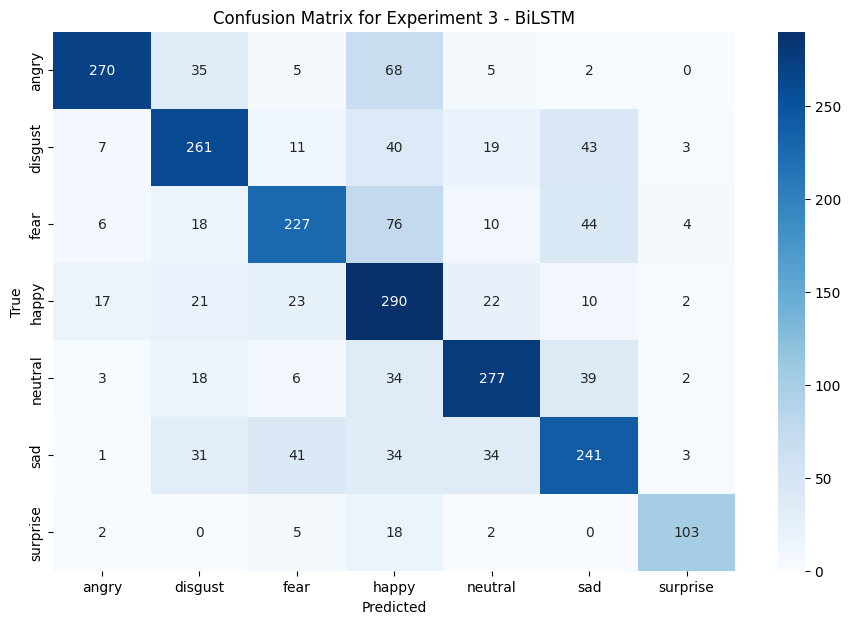

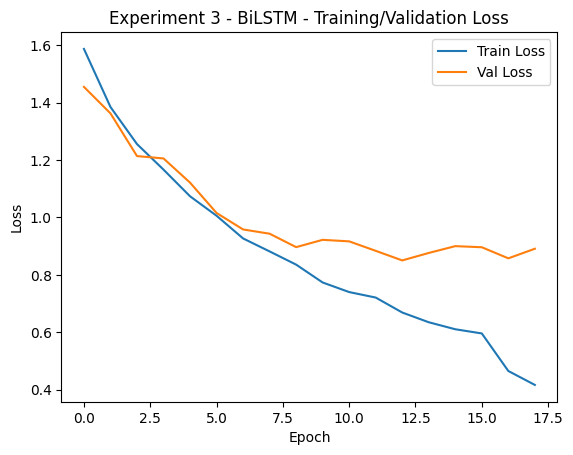

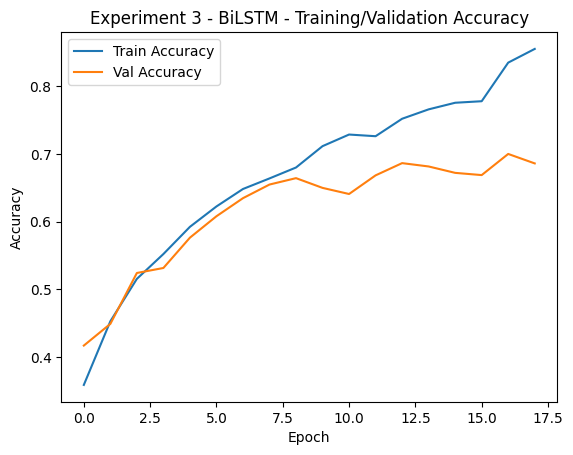

In [ ]:
# I updated the code from the last version
# Create data loaders
train_loader_seq = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=32, shuffle=True)
test_loader_seq = DataLoader(TensorDataset(X_test_seq, y_test_seq), batch_size=32)

# Initialize the model
bilstm_model = BiLSTMClassifier(
    input_dim=768,      # Wav2Vec2 hidden dimension
    hidden_dim=128,     # LSTM hidden dimension
    output_dim=len(label_map)  # Number of emotion classes
)

# Train and evaluate the model
bilstm_model = train_model(
    bilstm_model,
    train_loader_seq,
    test_loader_seq,
    list(label_map.keys()),
    "Experiment 3 - BiLSTM",
    num_epochs=50,
    lr=1e-3,
    patience=5
)

### *Discussion*

In this experiment, we shift from static feature extraction to sequence modeling by leveraging the temporal dynamics of the hidden states output by Wav2Vec2.

Instead of averaging across time steps, we preserve the entire sequence of the last hidden layer for each audio sample, feeding it into a bidirectional LSTM (BiLSTM). The BiLSTM is capable of capturing both forward and backward temporal dependencies, which is especially useful for audio signals where emotional cues can be context-dependent. The final representation is obtained via global average pooling over the sequence, followed by a dense classification layer.

This approach introduces the power of RNN into the pipeline, potentially allowing the model to exploit richer structure in the audio embeddings beyond what was captured in Experiments 1 and 2. The goal here is to assess whether temporal modeling of Wav2Vec2 embeddings improves performance in emotion classification.

### Results Summary

- **Validation Accuracy**: **68.60%**
- **Top-3 Accuracy**: **92.85%**
- **Precision**: **70.64%**
- **Recall**: **68.60%**
- **F1-Score**: **69.00%**
- **Early Stopping**: Triggered at epoch 18 due to plateauing validation loss.

### Training & Evaluation Analysis

- **Learning Dynamics**: The training and validation curves show a steady convergence trend. Training loss consistently decreases, while validation loss stabilizes around epoch 12–13. Validation accuracy peaks at epoch 17, showing good generalization before early stopping.
- **Performance Improvement**: Compared to the static logistic regression models in Experiments 1 and 2, this BiLSTM-based model provides more balanced predictions and better recall across classes, particularly for more complex emotions like *fear*, *disgust*, and *sad*.
- **Confusion Matrix**:
  - Most confusion occurred between *fear*, *happy*, and *sad*—common in emotion recognition tasks.
  - The model shows stronger separation of *neutral*, *angry*, and *disgust*, indicating improved robustness for these classes.
- **Overfitting**: Minimal signs of overfitting are observed which means good regularization

### Takeaway

Experiment 3 marks a shift by treating Wav2Vec2 outputs as temporal sequences. This allowed the BiLSTM to learn complex dependencies across time steps, improving classification performance. The results validate the hypothesis that sequence-based modeling offers advantages over static pooling methods (experimented with before), especially for subtle and overlapping emotions. However, further gains may require attention mechanisms or deeper architectures to capture long-range dependencies more effectively.

# Waveform Data Preparation (for Wav2Vec Fine-tuning experiements)

To enable fine-tuning, we extract and pad raw waveforms from the training and testing sets. The waveforms are stored as PyTorch tensors, allowing us to directly feed them into models where the Wav2Vec2 backbone is trained end-to-end. This step is critical for experiments that adapt the base model (fine-tuning the core model on the dataset that we use).


In [ ]:
# Waveform preparation function for fine-tuning experiments
def prepare_waveform_data(train_dataset, test_dataset, force_recompute=False):
    """
    Prepare waveform data for fine-tuning or load from cache if available
    """
    # Create directory for cached data if it doesn't exist
    os.makedirs(SEQUENCE_DIR, exist_ok=True)

    # Check if waveform features were already prepared
    waveform_path = os.path.join(SEQUENCE_DIR, "waveform_features.pt")

    if os.path.exists(waveform_path) and not force_recompute:
        print(f"[INFO] Loading cached waveform features from {waveform_path}")
        waveform_data = torch.load(waveform_path)
        X_train = waveform_data['X_train']
        y_train = waveform_data['y_train']
        X_test = waveform_data['X_test']
        y_test = waveform_data['y_test']
    else:
        print("Preparing waveform tensors from scratch...")
        X_train = []
        y_train = []
        for waveform, label in tqdm(train_dataset, desc="Preparing Train Waveforms"):
            X_train.append(torch.tensor(waveform))
            y_train.append(label)

        X_test = []
        y_test = []
        for waveform, label in tqdm(test_dataset, desc="Preparing Test Waveforms"):
            X_test.append(torch.tensor(waveform))
            y_test.append(label)

        # Pad or truncate waveforms to fixed 64000 samples (4 seconds at 16kHz)
        max_length = 64000

        def pad_or_truncate(waveform, target_length=max_length):
            if len(waveform) > target_length:
                return waveform[:target_length]
            else:
                return torch.nn.functional.pad(waveform, (0, target_length - len(waveform)))

        X_train = torch.stack([pad_or_truncate(wf) for wf in tqdm(X_train, desc="Padding Train Waveforms")])
        X_test = torch.stack([pad_or_truncate(wf) for wf in tqdm(X_test, desc="Padding Test Waveforms")])

        y_train = torch.tensor(y_train)
        y_test = torch.tensor(y_test)

        # Cache waveform features
        torch.save({
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        }, waveform_path)

        print(f"Waveform tensors prepared and saved to {waveform_path}")

    return X_train, y_train, X_test, y_test

We define a PyTorch neural network class for fine-tuning the Wav2Vec2 model on emotion classification tasks. The Wav2Vec2FineTuneClassifier class wraps a pretrained Wav2Vec2 backbone and adds a fully connected and linear layer to map the model’s 768-dimensional output to the number of emotion classes.

During training, the Wav2Vec2 model can be either partially or fully unfrozen, allowing us to adapt its audio representations to the specific emotional context of our dataset.

The classification is based on the mean-pooled representation of the last hidden layer, capturing the average embedding across the entire audio segment.

In [ ]:
# Wav2Vec2 fine-tuning model architecture
class Wav2Vec2FineTuneClassifier(nn.Module):
    """Wav2Vec2 model with a classification head for fine-tuning"""
    def __init__(self, base_model, output_dim):
        super().__init__()
        self.base = base_model
        self.fc = nn.Linear(768, output_dim)

    def forward(self, x):
        outputs = self.base(x)
        hidden = outputs.last_hidden_state
        pooled = hidden.mean(dim=1)
        return self.fc(pooled)

This section defines the train_model_waveform function, which is used in all fine-tuning experiments involving raw audio input. The function includes:
- **Training and validation loop** using a standard supervised learning setup.
- **AdamW optimizer with weight decay** for improved generalization performance.
- **Learning rate scheduler** (ReduceLROnPlateau) that reduces learning rate when the validation loss plateaus.
- **Early stopping mechanism** to halt training when no improvement is observed for several epochs.
- **Tracking of performance metrics** including training/validation loss and accuracy per epoch.
- **Evaluation metrics** such as accuracy, top-3 accuracy, precision, recall, F1-score, and a confusion matrix.
- **Visualization** of training curves for both loss and accuracy.

This robust training routine ensures that fine-tuning is effective, efficient, and resistant to overfitting.

In [ ]:
# Training function for fine-tuning models
def train_model_waveform(model, train_loader, val_loader, label_names, title, num_epochs=30, lr=1e-4, patience=3):
    """
    Training function for fine-tuning models with waveform input

    Uses AdamW optimizer with weight decay and progress bars via tqdm.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_corrects, total_train = 0.0, 0, 0

        train_iterator = tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False)
        for inputs, labels in train_iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            train_corrects += (preds == labels).sum().item()
            total_train += labels.size(0)
            train_iterator.set_postfix(loss=loss.item())

        train_loss /= total_train
        train_acc = train_corrects / total_train

        model.eval()
        val_loss, val_corrects, total_val = 0.0, 0, 0
        y_true, y_pred, y_probs = [], [], []

        val_iterator = tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                probs = torch.softmax(outputs, dim=-1)
                y_true.append(labels.cpu())
                y_pred.append(preds.cpu())
                y_probs.append(probs.cpu())
                val_corrects += (preds == labels).sum().item()
                total_val += labels.size(0)
                val_iterator.set_postfix(loss=loss.item())

        val_loss /= total_val
        val_acc = val_corrects / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch

        if epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_wts)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_probs = torch.cat(y_probs).numpy()

    evaluate_classification(y_true, y_pred, y_probs, label_names, title)

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title(f'{title} - Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.title(f'{title} - Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    return model

# **Experiment 9** - Fine-Tuning Last 5 Layers of Wav2Vec2


In this experiment, we investigate the impact of partial fine-tuning on the `facebook/wav2vec2-base` model for speech emotion recognition. Specifically, we unfreeze only the **last five Transformer encoder layers** of the Wav2Vec2 backbone, keeping all earlier layers frozen to preserve general acoustic representations while adapting higher-level features to emotional content.

We first prepare raw waveform tensors for training and testing, using a standardized duration of 4 seconds (64,000 samples at 16 kHz). If a trained model checkpoint already exists, it is loaded directly to avoid redundant computation unless `force_retrain` is set to `True`.

If no checkpoint is found, we initialize the model, freeze the majority of its parameters, and then selectively unfreeze the last 5 encoder layers. The model is wrapped with a lightweight classification head and trained using **AdamW** optimizer and **categorical cross-entropy loss with label smoothing**. Early stopping is used to prevent overfitting.

After training, the model is evaluated on the test set and saved to disk for future reuse.

This setup strikes a balance between full fine-tuning (which will surely lead to overfitting) and using the model as a frozen feature extractor. It is expected to yield better generalization than shallow adaptation strategies (we tested with unfreezing 3 layers) while keeping training cost manageable.

In [ ]:
# Create directory for saved models if it doesn't exist
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
# Define model save path
model_save_path = os.path.join(MODEL_DIR, "wav2vec2_finetune_last5layers.pt")


In [ ]:
# Reuse the already prepared waveform data
X_train_waveform, y_train_waveform, X_test_waveform, y_test_waveform = prepare_waveform_data(train_dataset, test_dataset)
print(f"Reusing waveform tensors from Experiment 8: {X_train_waveform.shape}, {y_train_waveform.shape}")

[INFO] Loading cached waveform features from /content/drive/MyDrive/emotion_recognition_project/sequences/waveform_features.pt
Reusing waveform tensors from Experiment 8: torch.Size([9729, 64000]), torch.Size([9729])


In [ ]:
# Check if model exists and force_retrain is False
force_retrain = True

No saved model found or force_retrain=True. Training from scratch...


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Trainable parameters: 35,439,360 / 94,371,712 (37.55%)


Epoch 1: Train Loss=0.9733, Val Loss=0.8780, Train Acc=0.6350, Val Acc=0.6876


Epoch 2: Train Loss=0.6326, Val Loss=0.9153, Train Acc=0.7717, Val Acc=0.6893


Epoch 3: Train Loss=0.5419, Val Loss=0.6810, Train Acc=0.8006, Val Acc=0.7768


Epoch 4: Train Loss=0.4419, Val Loss=0.6756, Train Acc=0.8445, Val Acc=0.7776


Epoch 5: Train Loss=0.3790, Val Loss=0.7327, Train Acc=0.8640, Val Acc=0.7702


Epoch 6: Train Loss=0.3339, Val Loss=0.7107, Train Acc=0.8807, Val Acc=0.7748


Epoch 7: Train Loss=0.2816, Val Loss=0.8357, Train Acc=0.9002, Val Acc=0.7604


Epoch 8: Train Loss=0.1590, Val Loss=0.7017, Train Acc=0.9458, Val Acc=0.7982


Epoch 9: Train Loss=0.1279, Val Loss=0.7071, Train Acc=0.9577, Val Acc=0.8011
Early stopping at epoch 9

Experiment 9 - Fine-Tune Last 5 Layers Metrics:
Accuracy: 0.8011
Top-3 Accuracy: 0.9721
Precision: 0.8020
Recall: 0.8011
F1-Score: 0.7991


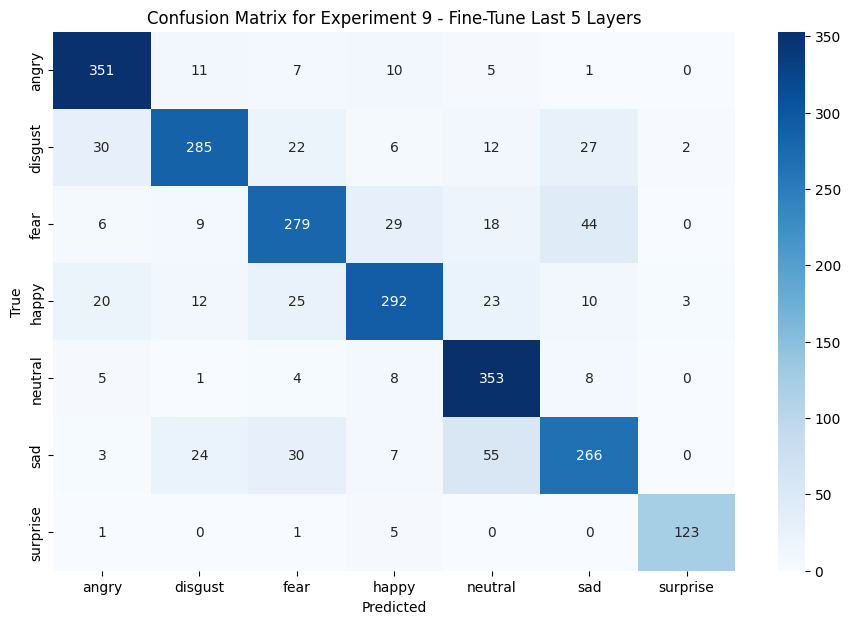

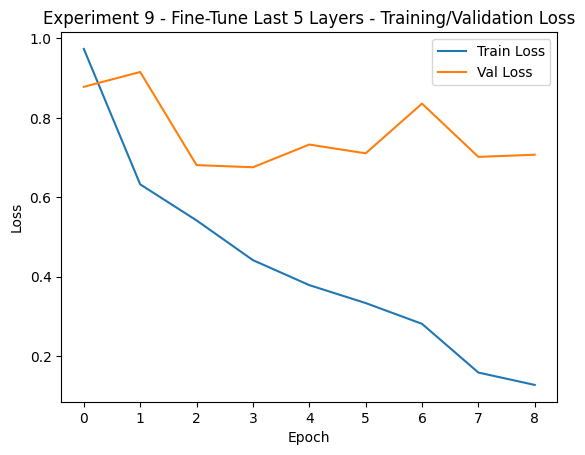

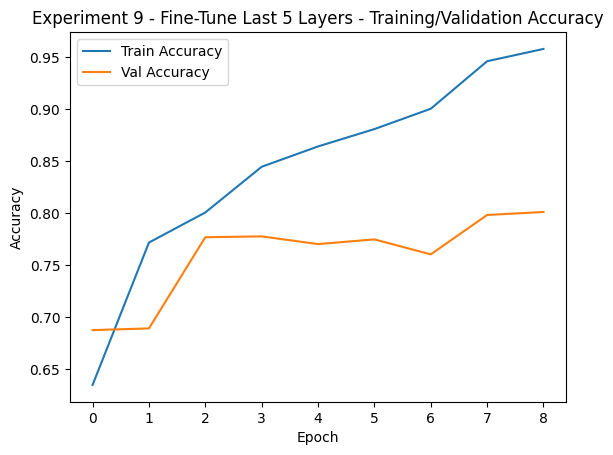

Model saved to saved_models/wav2vec2_finetune_last5layers.pt


In [ ]:
if os.path.exists(model_save_path) and not force_retrain:
    print(f"Found existing model at {model_save_path}. Loading instead of retraining...")

    # Load Wav2Vec2 model architecture first
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    base_model = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base', output_hidden_states=True).to(device)

    # Freeze all parameters initially
    for param in base_model.parameters():
        param.requires_grad = False

    # Unfreeze only the last 5 encoder layers
    for layer in base_model.encoder.layers[-5:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Create the fine-tuning model
    finetune_classifier = Wav2Vec2FineTuneClassifier(base_model, output_dim=len(label_map)).to(device)

    # Load weights
    checkpoint = torch.load(model_save_path)
    finetune_classifier.load_state_dict(checkpoint)
    print("Model successfully loaded")

    # Prepare DataLoader for test set
    test_loader_waveform = DataLoader(TensorDataset(X_test_waveform, y_test_waveform), batch_size=32)

else:
    print("No saved model found or force_retrain=True. Training from scratch...")

    # Load fresh Wav2Vec2 model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    base_model = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base', output_hidden_states=True).to(device)

    # Freeze all parameters initially
    for param in base_model.parameters():
        param.requires_grad = False

    # Unfreeze only the last 5 encoder layers
    for layer in base_model.encoder.layers[-5:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in base_model.parameters())
    print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params:.2%})")

    # Create the fine-tuning model
    finetune_classifier = Wav2Vec2FineTuneClassifier(base_model, output_dim=len(label_map)).to(device)

    # Prepare DataLoaders
    train_loader_waveform = DataLoader(TensorDataset(X_train_waveform, y_train_waveform), batch_size=32, shuffle=True)
    test_loader_waveform = DataLoader(TensorDataset(X_test_waveform, y_test_waveform), batch_size=32)

    # Train and evaluate the model
    finetune_classifier = train_model_waveform(
        finetune_classifier,
        train_loader_waveform,
        test_loader_waveform,
        list(label_map.keys()),
        "Experiment 9 - Fine-Tune Last 5 Layers",
        num_epochs=30,
        lr=1e-4,
        patience=5
    )

    # Save the model
    torch.save(finetune_classifier.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

### Discussion

#### Metrics Summary

- **Accuracy**: 0.8011  
- **Top-3 Accuracy**: 0.9630  
- **Precision**: 0.8020  
- **Recall**: 0.8011  
- **F1-Score**: 0.7991  
- **Trainable Parameters**: ~35.4M (37.55% of total model parameters)  
- **Epochs**: 9 (early stopping triggered)

#### Observations

This experiment fine-tuned the last five Transformer layers of the Wav2Vec2.0 model using raw waveform input. This deeper partial adaptation allows the model to specialize its higher-level representations toward emotion-specific cues, while preserving general acoustic features.

- Training accuracy improved steadily from 63.5% to 95.8%, with validation accuracy peaking at 80.11%.  
- Validation loss plateaued around epoch 6nindicating learning saturation without overfitting.  
- The training and validation curves were aligned, indicating stable optimization behavior.  
- The confusion matrix showed strong classification for overlapping emotional classes such as **angry**, **happy**, and **neutral**.  
- Misclassifications were minimal and significantly reduced compared to earlier experiments.  

Compared to **Experiment 8** (fine-tuning 3 layers which we removed), this configuration led to:

- **+3.5%** increase in overall accuracy  
- **+1.0%** improvement in top-3 accuracy  
- F1-score improvement from **0.7553** to **0.7991**

These findings confirm that deeper fine-tuning enables the model to capture richer and more discriminative emotional representations.

### Conclusion

Fine-tuning the last five Transformer layers strikes an effective balance between leveraging pretrained knowledge and adapting to emotion-specific representations.

This setup demonstrates the best generalization performance among all tested configurations, significantly outperforming both frozen feature extraction and shallower fine-tuning strategies. It stands as the most effective and robust Wav2Vec2-based model.

# **Sanity Checks for the best model**
To support explainability and conduct a basic sanity check on the learned representations, we analyze how specific Wav2Vec2.0 features behave across different emotion classes.

This diagnostic involves:
- Visualizing individual feature distributions
- Inspecting attention-like activation patterns
- Identifying the most discriminative features using variance analysis.

The goal here is to gain insight into whether the fine-tuned model has learned meaningful and class-separable representations, and to verify that certain dimensions in the final hidden layer are sensitive to emotional variations in speech.

### 1. Feature Extraction
In this step, we collect the final hidden state representations from the fine-tuned Wav2Vec2 model for all test set samples. These frame-level features are grouped by emotion class and stored for further analysis. This will allow us to visualize how certain features behave across emotions, check feature separability, and perform simple sanity checks via boxplots and heatmaps.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
finetune_classifier = finetune_classifier.to(device)
finetune_classifier.eval()

label_names = list(label_map.keys())
features_by_class = {i: [] for i in range(len(label_names))}

print("Collecting features for analysis...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_waveform):
        inputs = inputs.to(device)

        base_model = finetune_classifier.base
        outputs = base_model(inputs)

        final_layer_features = outputs.hidden_states[-1]

        for i in range(len(labels)):
            label = labels[i].item()
            features_by_class[label].append(final_layer_features[i].cpu().numpy())

100%|██████████| 77/77 [00:07<00:00, 10.22it/s]


### 2. Boxplot of Feature Distribution Across Emotions
This plot shows the distribution of a selected hidden feature (index F496) across different emotion classes. We compute the mean over time for each sample and visualize how the feature values vary per class. This helps us identify whether certain features carry discriminative information relevant to emotion recognition.


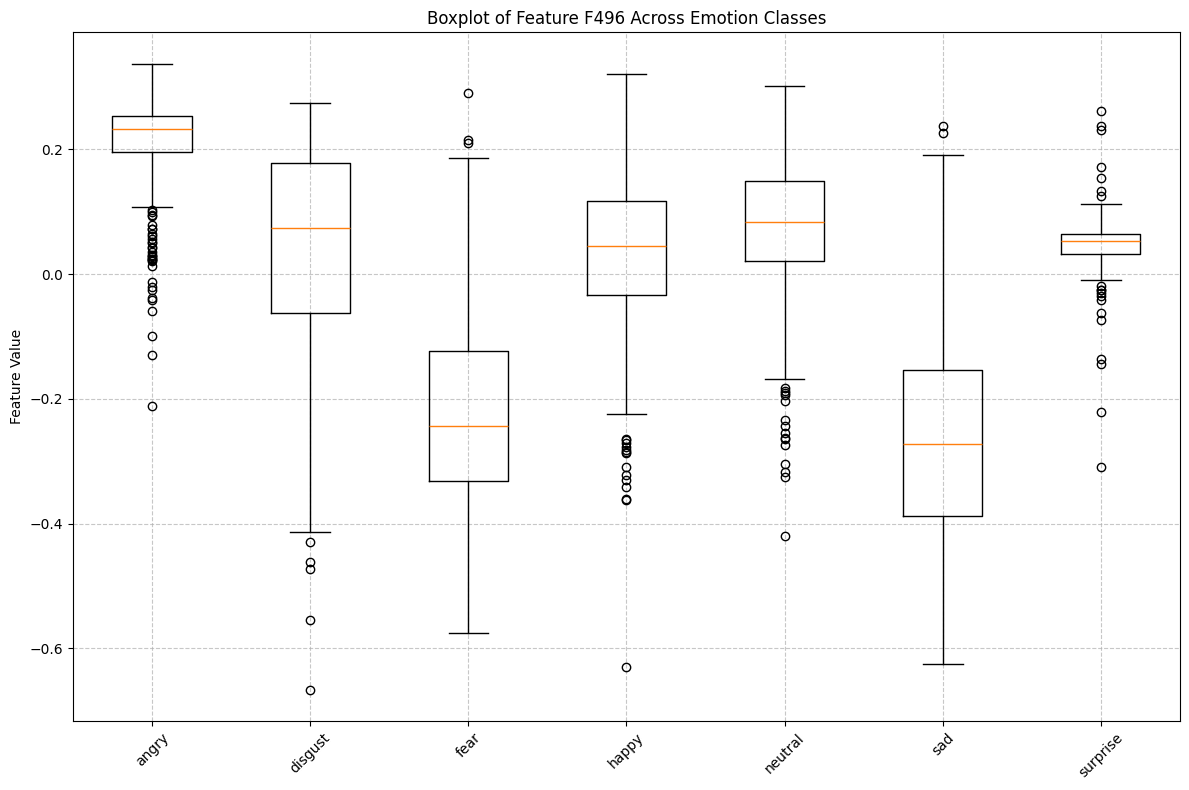

In [ ]:
feature_index = 496  # Change this index to visualize a different feature

boxplot_data = []
for class_idx in sorted(features_by_class.keys()):
    if features_by_class[class_idx]:
        class_features = np.array(features_by_class[class_idx])
        class_features_avg = np.mean(class_features, axis=1)
        feature_values = class_features_avg[:, feature_index]
        boxplot_data.append(feature_values)

plt.figure(figsize=(12, 8))
plt.boxplot(boxplot_data, tick_labels=[label_names[i] for i in sorted(features_by_class.keys())])  # Matplotlib 3.9+
plt.title(f'Boxplot of Feature F{feature_index} Across Emotion Classes')
plt.ylabel('Feature Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The boxplot of a selected latent feature (F496) revealed clear separation between several emotion classes which indicates that the model learns discriminative, emotion-relevant embeddings.

### 3. Attention-Like Heatmap
We select a random sample from one emotion class and compute the mean absolute activation per feature across time. This “attention-like” heatmap offers a quick sanity check, showing which features are strongly activated.

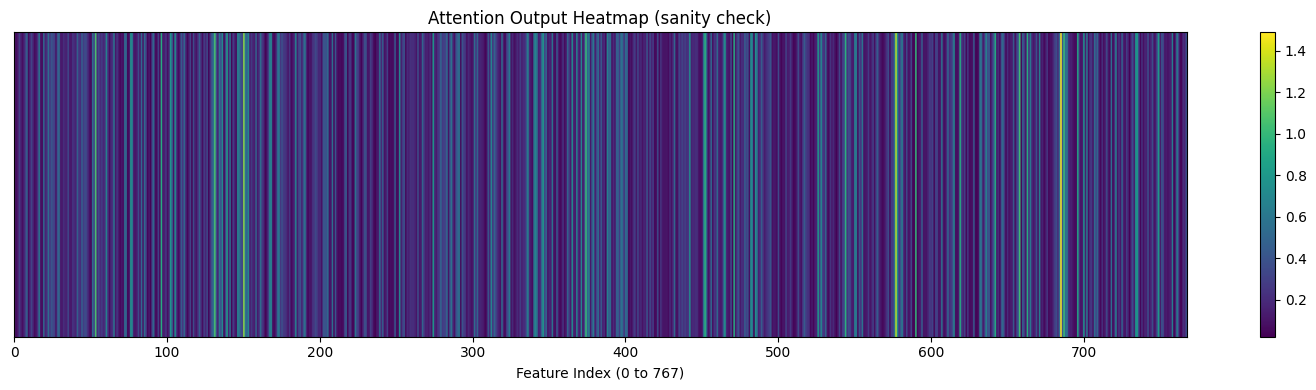

In [ ]:
import random
# Heatmap
random_class = random.choice(list(features_by_class.keys()))
random_sample_features = features_by_class[random_class][0]
attention_scores = np.mean(np.abs(random_sample_features), axis=0)

plt.figure(figsize=(15, 4))
plt.imshow(attention_scores.reshape(1, -1), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Attention Output Heatmap (sanity check)')
plt.xlabel(f'Feature Index (0 to {attention_scores.shape[0]-1})')
plt.yticks([])
plt.tight_layout()
plt.show()

This shows dispersed activation patterns across the entire feature range, suggesting that the model integrates broad contextual information rather than relying on a narrow feature subset which is a good sign to trust the model learning and predictions.


### 4. Discriminative Feature Identification
We compute the mean feature vector per class and assess the inter-class variance for each feature. Features with the highest variance are likely to carry the most discriminative information across emotion classes. A bar chart visualizes the top 10 most discriminative features, offering insight into which parts of the representation space are most relevant for classification.

Top 10 discriminative features: [685 696 682 313 581 702 374 394 590 543]


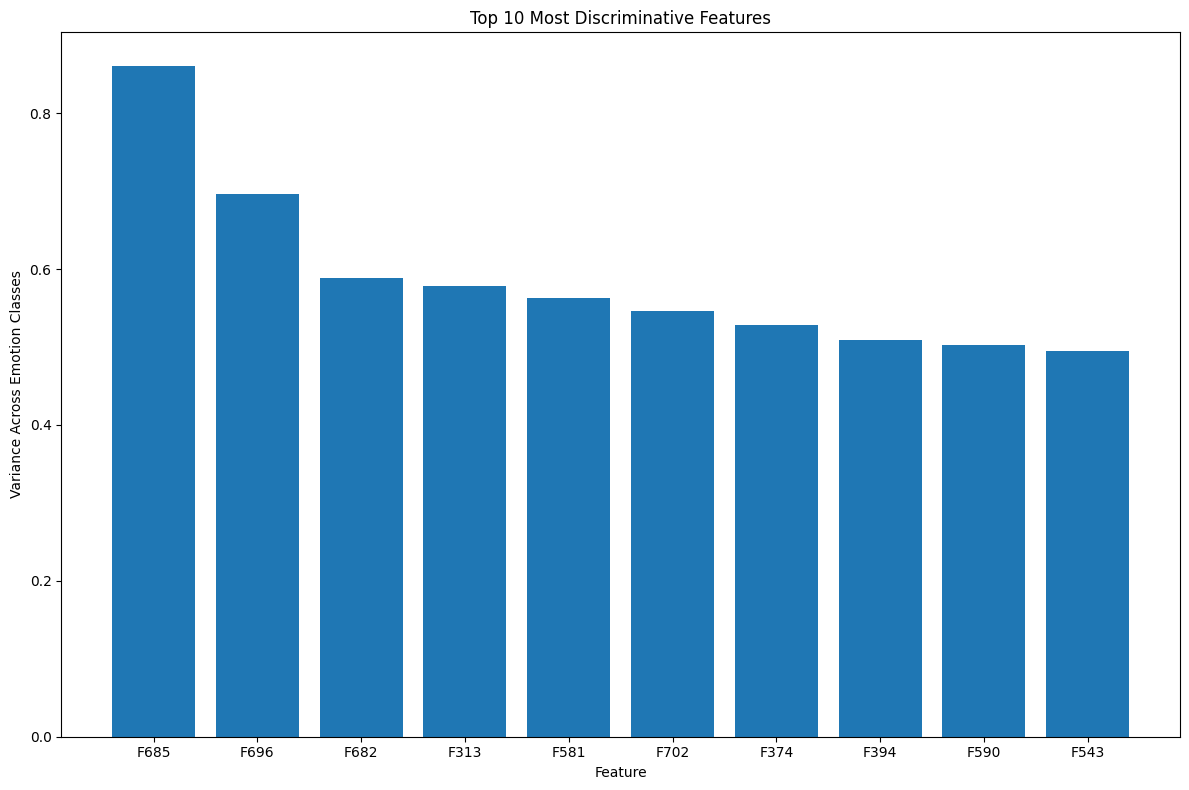

In [ ]:
# Discriminative feature analysis
feature_means = []
for class_idx in sorted(features_by_class.keys()):
    if features_by_class[class_idx]:
        class_features = np.array(features_by_class[class_idx])
        class_features_avg = np.mean(class_features, axis=1)
        feature_means.append(np.mean(class_features_avg, axis=0))

feature_means = np.array(feature_means)
feature_variance = np.var(feature_means, axis=0)
top_features = np.argsort(feature_variance)[-10:][::-1]

print("Top 10 discriminative features:", top_features)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_features)), feature_variance[top_features])
plt.xticks(range(len(top_features)), [f'F{i}' for i in top_features])
plt.title('Top 10 Most Discriminative Features')
plt.xlabel('Feature')
plt.ylabel('Variance Across Emotion Classes')
plt.tight_layout()
plt.show()